In [81]:
import pandas as pd
import json
import folium
import requests
import geocoder
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn.metrics
import seaborn as sns

In [2]:
# Open GeoJson File of Cologne
with open('bezirke.json', encoding='utf8') as f:
    data = json.load(f)

In [3]:
# What attributes are available:
print(data['features'][0]['attributes'].keys())

dict_keys(['OBJECTID', 'NUMMER', 'NAME', 'NR_STADTBEZIRK', 'STADTBEZIRK', 'FLAECHE', 'LINK'])


In [4]:
# Look at all the neighborhoods
print([x['attributes']['NAME'] for x in data['features']])

['Godorf', 'Lövenich', 'Weiden', 'Junkersdorf', 'Widdersdorf', 'Vogelsang', 'Weidenpesch', 'Mauenheim', 'Marienburg', 'Bayenthal', 'Weiß', 'Hahnwald', 'Meschenich', 'Immendorf', 'Buchforst', 'Höhenberg', 'Vingst', 'Grengel', 'Elsdorf', 'Wahnheide', 'Wahn', 'Libur', 'Lind', 'Ensen', 'Eil', 'Raderthal', 'Raderberg', 'Rondorf', 'Holweide', 'Buchheim', 'Merheim', 'Neubrück', 'Ostheim', 'Westhoven', 'Bocklem./Mengenich', 'Dünnwald', 'Höhenhaus', 'Poll', 'Humboldt/Gremb.', 'Deutz', 'Bickendorf', 'Sürth', 'Rodenkirchen', 'Urbach', 'Niehl', 'Flittard', 'Dellbrück', 'Rath/Heumar', 'Brück', 'Altstadt-Nord', 'Neustadt-Süd', 'Müngersdorf', 'Roggendorf/Thenh.', 'Zündorf', 'Langel', 'Zollstock', 'Porz', 'Altstadt-Süd', 'Neustadt-Nord', 'Kalk', 'Braunsfeld', 'Ossendorf', 'Neuehrenfeld', 'Esch/Auweiler', 'Pesch', 'Volkhoven/Weiler', 'Heimersdorf', 'Chorweiler', 'Seeberg', 'Lindweiler', 'Worringen', 'Riehl', 'Nippes', 'Lindenthal', 'Sülz', 'Klettenberg', 'Bilderstöckchen', 'Longerich', 'Gremberghoven',

In [5]:
# Define a function to find a centroid from a polygon
def centroid(vertexes):
     _x_list = [vertex [0] for vertex in vertexes]
     _y_list = [vertex [1] for vertex in vertexes]
     _len = len(vertexes)
     _x = sum(_x_list) / _len
     _y = sum(_y_list) / _len
     return(_x, _y)

In [6]:
# For example: center of district 'Riehl'
district = 'Riehl'
centroid([x['geometry']['rings'] for x in data['features'] if x['attributes']['NAME'] ==district][0][0])

(6.976239810086273, 50.96412751940114)

In [7]:
def get_centroid_for_district(name):
    return centroid([x['geometry']['rings'] for x in data['features'] if x['attributes']['NAME'] == name][0][0])

In [8]:
[x['geometry']['rings'] for x in data['features'] if x['attributes']['NAME'] == 'Riehl'][0][0]

[[6.977479683511139, 50.970721880850355],
 [6.980119012497131, 50.97048841023769],
 [6.981596362866539, 50.9703861934855],
 [6.982657748963986, 50.970300338411924],
 [6.983427841420929, 50.97023307606834],
 [6.983825325349048, 50.970198258787754],
 [6.984737656708249, 50.97011901158084],
 [6.985896896595708, 50.96996791456337],
 [6.986205229391666, 50.96989231639894],
 [6.986601863890959, 50.96976455311553],
 [6.9869491913128, 50.969634688317264],
 [6.987212171498334, 50.969501759577774],
 [6.987563640874519, 50.969278729466524],
 [6.987830242376384, 50.969054976914514],
 [6.988097217069494, 50.968748339834356],
 [6.988322897177964, 50.96843477067262],
 [6.988436151961165, 50.96820368539382],
 [6.988550977771627, 50.96787235639431],
 [6.988608862565332, 50.96771080424992],
 [6.988697336512682, 50.96751091544881],
 [6.988858642316579, 50.96722332985074],
 [6.989021445721937, 50.96700416865461],
 [6.989139654484342, 50.96685356982134],
 [6.989388556410648, 50.9666420101665],
 [6.98976443

In [9]:
df_cologne = pd.DataFrame(columns=['District', 'Latitude', 'Longitude', 'Area', 'Polygon'])
df_cologne['District'] = [x['attributes']['NAME'] for x in data['features']]
df_cologne['Latitude'] = df_cologne['District'].apply(get_centroid_for_district).apply(lambda i: i[1])
df_cologne['Longitude'] = df_cologne['District'].apply(get_centroid_for_district).apply(lambda i: i[0])
df_cologne['Area'] = [x['attributes']['FLAECHE'] for x in data['features']]
df_cologne['Polygon'] = df_cologne['District'].apply(lambda d: [x['geometry']['rings'] for x in data['features'] if x['attributes']['NAME'] == d][0][0])
df_cologne.head()

District   Latitude  Longitude     Area  \
0       Godorf  50.852610   6.982218  4592631   
1     Lövenich  50.948533   6.823829  3692013   
2       Weiden  50.934514   6.824246  3654710   
3  Junkersdorf  50.923891   6.859688  7376623   
4  Widdersdorf  50.967660   6.841605  5599212   

                                             Polygon  
0  [[6.994359341598065, 50.85835989408827], [6.99...  
1  [[6.835101297207516, 50.957260493877406], [6.8...  
2  [[6.849501526802686, 50.94220412958467], [6.84...  
3  [[6.854198181651118, 50.94052346246431], [6.85...  
4  [[6.851763526592514, 50.97718504868292], [6.85...

In [10]:
address = 'Cologne, DE'

geolocator = Nominatim(user_agent="cologne_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cologne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cologne are 50.938361, 6.959974.


In [11]:
# create map and display it
cologne_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
districts = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, label in zip(df_cologne.Latitude, df_cologne.Longitude, df_cologne.District):
    districts.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=label
        )
    )

# add incidents to map
cologne_map.add_child(districts)

In [12]:
# Explore

In [13]:
CLIENT_ID = 'K0OBBE3XME1ORY4POM5AWPU1BI01AGX01IIDL5EL4D005UA4' # your Foursquare ID
CLIENT_SECRET = 'APU0I3ENTYA0Z2NHBT1T3RREEH2GBPRF5AHSFYCZVB4TCU1O' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
LIMIT = 100
cologne_venues = getNearbyVenues(names=df_cologne['District'],
                                   latitudes=df_cologne['Latitude'],
                                   longitudes=df_cologne['Longitude'],
                                  radius=500)

Godorf
Lövenich
Weiden
Junkersdorf
Widdersdorf
Vogelsang
Weidenpesch
Mauenheim
Marienburg
Bayenthal
Weiß
Hahnwald
Meschenich
Immendorf
Buchforst
Höhenberg
Vingst
Grengel
Elsdorf
Wahnheide
Wahn
Libur
Lind
Ensen
Eil
Raderthal
Raderberg
Rondorf
Holweide
Buchheim
Merheim
Neubrück
Ostheim
Westhoven
Bocklem./Mengenich
Dünnwald
Höhenhaus
Poll
Humboldt/Gremb.
Deutz
Bickendorf
Sürth
Rodenkirchen
Urbach
Niehl
Flittard
Dellbrück
Rath/Heumar
Brück
Altstadt-Nord
Neustadt-Süd
Müngersdorf
Roggendorf/Thenh.
Zündorf
Langel
Zollstock
Porz
Altstadt-Süd
Neustadt-Nord
Kalk
Braunsfeld
Ossendorf
Neuehrenfeld
Esch/Auweiler
Pesch
Volkhoven/Weiler
Heimersdorf
Chorweiler
Seeberg
Lindweiler
Worringen
Riehl
Nippes
Lindenthal
Sülz
Klettenberg
Bilderstöckchen
Longerich
Gremberghoven
Ehrenfeld
Finkenberg
Merkenich
Fühlingen
Blumenberg
Stammheim
Mülheim


In [16]:
cologne_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Godorf              50.852610                6.982218   
1       Godorf              50.852610                6.982218   
2       Godorf              50.852610                6.982218   
3     Lövenich              50.948533                6.823829   
4     Lövenich              50.948533                6.823829   

                              Venue  Venue Latitude  Venue Longitude  \
0                      Godorf Hafen       50.848477         6.982683   
1                   Bude Pausenraum       50.852996         6.988761   
2                   Godorfer Imbiss       50.852567         6.975184   
3  Bäckerei Kraus - Lövenicher Café       50.946507         6.829737   
4                     Alte Schmiede       50.946739         6.829642   

    Venue Category  
0  Harbor / Marina  
1   Breakfast Spot  
2      Snack Place  
3           Bakery  
4        Gastropub

In [17]:
# Clustering to see similar districts in cologne
# one hot encoding
cologne_onehot = pd.get_dummies(cologne_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cologne_onehot['Neighborhood'] = cologne_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cologne_onehot.columns[-1]] + list(cologne_onehot.columns[:-1])
cologne_onehot = cologne_onehot[fixed_columns]

cologne_onehot.head()

Neighborhood  African Restaurant  Airport Service  Argentinian Restaurant  \
0       Godorf                   0                0                       0   
1       Godorf                   0                0                       0   
2       Godorf                   0                0                       0   
3     Lövenich                   0                0                       0   
4     Lövenich                   0                0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           0                    0                 0   

   Athletics & Sports  Automotive Shop     ...       Turkish Restaurant  \
0                   0                0     ...                        0   
1                   0                0     ...                        0   
2                   0                0     ...                        0   
3                   0                0     ...                        0   
4                   0                0     ...                        0   

   Vacation Rental  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                0                              0                      0   
1                0                              0                      0   
2                0                              0                      0   
3                0                              0                      0   
4                0                              0                      0   

   Water Park  Waterfront  Wine Bar  Wine Shop  Zoo  Zoo Exhibit  
0           0           0         0          0    0            0  
1           0           0         0          0    0            0  
2           0           0         0          0    0            0  
3           0           0         0          0    0            0  
4           0           0         0          0    0            0  

[5 rows x 192 columns]

In [18]:
cologne_grouped = cologne_onehot.groupby('Neighborhood').mean().reset_index()
cologne_grouped.head()

Neighborhood  African Restaurant  Airport Service  \
0    Altstadt-Nord                 0.0             0.01   
1     Altstadt-Süd                 0.0             0.00   
2        Bayenthal                 0.0             0.00   
3       Bickendorf                 0.0             0.00   
4  Bilderstöckchen                 0.0             0.00   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0    0.020000                 0.01   
1                     0.0          0.0    0.026316                 0.00   
2                     0.0          0.0    0.000000                 0.00   
3                     0.0          0.0    0.000000                 0.00   
4                     0.0          0.0    0.000000                 0.00   

   Asian Restaurant  Athletics & Sports  Automotive Shop     ...       \
0          0.010000            0.000000              0.0     ...        
1          0.026316            0.000000              0.0     ...        
2          0.000000            0.000000              0.0     ...        
3          0.000000            0.083333              0.0     ...        
4          0.000000            0.000000              0.0     ...        

   Turkish Restaurant  Vacation Rental  Vegetarian / Vegan Restaurant  \
0                 0.0              0.0                       0.010000   
1                 0.0              0.0                       0.026316   
2                 0.0              0.0                       0.000000   
3                 0.0              0.0                       0.000000   
4                 0.0              0.0                       0.000000   

   Vietnamese Restaurant  Water Park  Waterfront  Wine Bar  Wine Shop  Zoo  \
0               0.000000    0.000000         0.0      0.01        0.0  0.0   
1               0.026316    0.026316         0.0      0.00        0.0  0.0   
2               0.000000    0.000000         0.0      0.00        0.0  0.0   
3               0.000000    0.000000         0.0      0.00        0.0  0.0   
4               0.000000    0.000000         0.0      0.00        0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 192 columns]

In [19]:
num_top_venues = 3

for hood in cologne_grouped['Neighborhood']:
    print("{:-^30}".format(hood))
    temp = cologne_grouped[cologne_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

--------Altstadt-Nord---------
                venue  freq
0  Italian Restaurant  0.07
1                Café  0.06
2              Bakery  0.05


---------Altstadt-Süd---------
              venue  freq
0             Hotel  0.16
1  Sushi Restaurant  0.08
2              Café  0.08


----------Bayenthal-----------
         venue  freq
0  Supermarket  0.16
1       Bakery  0.08
2     Bus Stop  0.08


----------Bickendorf----------
         venue  freq
0          Pub  0.17
1  Supermarket  0.17
2         Bank  0.08


-------Bilderstöckchen--------
       venue  freq
0   Bus Stop  0.50
1  Drugstore  0.25
2       Café  0.25


------Bocklem./Mengenich------
              venue  freq
0  Greek Restaurant  0.25
1      Intersection  0.25
2      Soccer Field  0.25


----------Braunsfeld----------
               venue  freq
0             Bakery  0.18
1          Drugstore  0.12
2  German Restaurant  0.12


------------Brück-------------
                venue  freq
0              Forest   0.5
1         

                venue  freq
0    Insurance Office   1.0
1  African Restaurant   0.0
2        Perfume Shop   0.0


-----------Seeberg------------
                venue  freq
0  Turkish Restaurant  0.50
1      Discount Store  0.25
2  Light Rail Station  0.25


----------Stammheim-----------
            venue  freq
0     Supermarket  0.25
1  Ice Cream Shop  0.25
2        Pharmacy  0.25


-------------Sülz-------------
                   venue  freq
0                 Bakery  0.14
1  Vietnamese Restaurant  0.14
2                    Pub  0.07


------------Sürth-------------
               venue  freq
0       Tram Station   0.2
1        Supermarket   0.2
2  German Restaurant   0.2


------------Urbach------------
               venue  freq
0          Drugstore  0.11
1        Pizza Place  0.11
2  Electronics Store  0.11


------------Vingst------------
           venue  freq
0    Supermarket  0.31
1         Bakery  0.23
2  Metro Station  0.08


----------Vogelsang-----------
                v

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cologne_grouped['Neighborhood']

for ind in np.arange(cologne_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cologne_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted[neighborhoods_venues_sorted.Neighborhood == "Riehl"]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
59        Riehl           Zoo Exhibit          Tram Station   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
59                Garden                  Café           Snack Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
59           Supermarket                Bakery     German Restaurant   

   9th Most Common Venue 10th Most Common Venue  
59                   Zoo         Ice Cream Shop

In [22]:
# set number of clusters
kclusters = 10

cologne_grouped_clustering = cologne_grouped.drop('Neighborhood', 1)
for i in cologne_grouped_clustering.columns:
    cologne_grouped_clustering[i] = preprocessing.minmax_scale(cologne_grouped_clustering[i].astype('float64'))

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cologne_grouped_clustering)

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cologne_merged = df_cologne

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cologne_merged = cologne_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')

cologne_merged

District   Latitude  Longitude      Area  \
0             Godorf  50.852610   6.982218   4592631   
1           Lövenich  50.948533   6.823829   3692013   
2             Weiden  50.934514   6.824246   3654710   
3        Junkersdorf  50.923891   6.859688   7376623   
4        Widdersdorf  50.967660   6.841605   5599212   
5          Vogelsang  50.960676   6.875571   3649388   
6        Weidenpesch  50.981277   6.943294   3908220   
7          Mauenheim  50.974533   6.944026    488493   
8         Marienburg  50.900442   6.969971   3046374   
9          Bayenthal  50.908680   6.966327   1284438   
10              Weiß  50.881156   7.033908   4159650   
11          Hahnwald  50.872604   6.984390   2993683   
12        Meschenich  50.853538   6.928561   4719852   
13         Immendorf  50.851447   6.954945   5202232   
14         Buchforst  50.950074   7.004112    830680   
15         Höhenberg  50.941855   7.025073   2194472   
16            Vingst  50.932077   7.023803   1124166   
17           Grengel  50.870957   7.122551  10657044   
18           Elsdorf  50.871000   7.081858   1766220   
19         Wahnheide  50.862192   7.110417   2876371   
20              Wahn  50.859633   7.084996   2262278   
21             Libur  50.844240   7.072192   6375840   
22              Lind  50.849098   7.108139   2242850   
23             Ensen  50.899258   7.036880   1618151   
24               Eil  50.899556   7.100911  16246423   
25         Raderthal  50.896836   6.953965   3205968   
26         Raderberg  50.910561   6.958037    836694   
27           Rondorf  50.877478   6.934024   8200253   
28          Holweide  50.964209   7.048647   4110537   
29          Buchheim  50.958775   7.021337   2854853   
..               ...        ...        ...       ...   
56              Porz  50.884047   7.062007   3117290   
57      Altstadt-Süd  50.930917   6.951047   2361133   
58     Neustadt-Nord  50.943877   6.943804   3489554   
59              Kalk  50.940506   7.005982   2967093   
60        Braunsfeld  50.940041   6.896742   1680549   
61         Ossendorf  50.977418   6.896325   6808228   
62      Neuehrenfeld  50.957461   6.924259   2548309   
63     Esch/Auweiler  51.008858   6.845227   7611104   
64             Pesch  50.997712   6.876867   2832393   
65  Volkhoven/Weiler  51.021040   6.876272   4353197   
66       Heimersdorf  51.009752   6.898149   1745384   
67        Chorweiler  51.026625   6.897860   1918502   
68           Seeberg  51.019679   6.909125   1780432   
69        Lindweiler  51.004521   6.888348   1156407   
70         Worringen  51.063942   6.854580  11725232   
71             Riehl  50.964128   6.976240   2389883   
72            Nippes  50.966772   6.957085   2998062   
73        Lindenthal  50.926257   6.906772   7688801   
74              Sülz  50.915698   6.917798   5174351   
75       Klettenberg  50.906936   6.921745   1795311   
76   Bilderstöckchen  50.970391   6.928229   3763759   
77         Longerich  50.995001   6.923908   6140437   
78     Gremberghoven  50.910542   7.044078   5996911   
79         Ehrenfeld  50.949339   6.910822   3716535   
80        Finkenberg  50.897457   7.064346    637532   
81         Merkenich  51.033502   6.940967  12198183   
82         Fühlingen  51.033309   6.912747   4862080   
83        Blumenberg  51.040677   6.873809   3221873   
84         Stammheim  50.989277   6.993882   3741681   
85           Mülheim  50.965368   6.999677   7065806   

                                              Polygon  Cluster Labels  \
0   [[6.994359341598065, 50.85835989408827], [6.99...             3.0   
1   [[6.835101297207516, 50.957260493877406], [6.8...             3.0   
2   [[6.849501526802686, 50.94220412958467], [6.84...             6.0   
3   [[6.854198181651118, 50.94052346246431], [6.85...             3.0   
4   [[6.851763526592514, 50.97718504868292], [6.85...             1.0   
5   [[6.8724234275435485, 50.97622549898243], [6.8...             3.0   
6   [[6.938775418811381, 50.

In [24]:
cologne_merged.dropna(inplace=True)
cologne_merged['Cluster Labels'] = cologne_merged['Cluster Labels'].astype(int)

In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cologne_merged['Latitude'], cologne_merged['Longitude'], cologne_merged['District'], cologne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Area Usage

In [26]:
# Open GeoJson File of Cologne
with open('flaeche.json', encoding='utf8') as f:
    data = json.load(f)

In [27]:
df_cologne_area = pd.DataFrame(columns=['District','built-up', 'park', 'traffic', 'water'])
for district in data['features']:
    df_cologne_area = df_cologne_area.append(
        {
            'District': district['properties']['NAME'],
            'built-up': district['properties']['FN_BEBAUT_AP'],
            'park': district['properties']['FN_PARK_AP'],
            'traffic': district['properties']['FN_VERKEHR_AP'],
            'water': district['properties']['FN_WASSER_AP']
        }, ignore_index=True
    )
df_cologne_area.head()

District  built-up  park  traffic water
0       Mülheim      52.1    10     24.6    10
1    Braunsfeld      68.5   1.2     26.8     0
2     Ossendorf      41.4  24.5     15.1     0
3          Porz      61.2   6.1     19.9     9
4  Altstadt-Süd      54.7   4.2     30.9  10.2

In [28]:
# set number of clusters
kclusters = 6

c_area_grouped_clustering = df_cologne_area.drop('District', 1) / 100

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(c_area_grouped_clustering)

In [29]:
# add clustering labels
df_cologne_area_with_lables = df_cologne_area.copy()
df_cologne_area_with_lables.insert(len(df_cologne_area_with_lables.columns), 'Area Cluster Labels', kmeans.labels_)

df_cologne_area_with_lables.head()

df_cologne_merged_area = df_cologne_area_with_lables.merge(df_cologne[['District', 'Latitude', 'Longitude']], on='District', how='outer')
df_cologne_merged_area.head()

District  built-up  park  traffic water  Area Cluster Labels  \
0       Mülheim      52.1    10     24.6    10                    2   
1    Braunsfeld      68.5   1.2     26.8     0                    5   
2     Ossendorf      41.4  24.5     15.1     0                    4   
3          Porz      61.2   6.1     19.9     9                    5   
4  Altstadt-Süd      54.7   4.2     30.9  10.2                    2   

    Latitude  Longitude  
0  50.965368   6.999677  
1  50.940041   6.896742  
2  50.977418   6.896325  
3  50.884047   7.062007  
4  50.930917   6.951047

In [30]:
df_cologne_merged_area[df_cologne_merged_area.isna().any(axis=1)]

Empty DataFrame
Columns: [District, built-up, park, traffic, water, Area Cluster Labels, Latitude, Longitude]
Index: []

In [31]:
# create map
map_clusters_area = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cologne_merged_area['Latitude'], df_cologne_merged_area['Longitude'], df_cologne_merged_area['District'], df_cologne_merged_area['Area Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_area)
       
map_clusters_area

In [32]:
# Open GeoJson File of Cologne without encoding
with open('flaeche.json') as f:
    data = json.load(f)
df_cologne_area_encNone = pd.DataFrame(columns=['District','built-up', 'park', 'traffic', 'water'])
for district in data['features']:
    df_cologne_area_encNone = df_cologne_area_encNone.append(
        {
            'District': district['properties']['NAME'],
            'built-up': district['properties']['FN_BEBAUT_AP'],
            'park': district['properties']['FN_PARK_AP'],
            'traffic': district['properties']['FN_VERKEHR_AP'],
            'water': district['properties']['FN_WASSER_AP']
        }, ignore_index=True
    )

In [33]:
from folium import plugins
cc_map = folium.Map(location=[latitude, longitude],zoom_start=12)

folium.Choropleth(
    geo_data='flaeche.json',
    name='Water',
    data=df_cologne_area_encNone,
    columns=['District', 'water'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Water Density'
).add_to(cc_map)

cc_map

# Households

In [34]:
# Open GeoJson File of Cologne
with open('haushalte.json', encoding='utf8') as f:
    data = json.load(f)

In [35]:
df_cologne_household = pd.DataFrame(columns=['District','density', 'ratio-1P', 'ratio-2P', 'ratio-3P', 'ratio-4P', 'ratio-5P+'])
for district in data['features']:
    df_cologne_household = df_cologne_household.append(
        {
            'District': district['properties']['NAME'],
            'density': district['properties']['HHD_AP'],
            'ratio-1P': district['properties']['HH_HG_1PERS_AP'],
            'ratio-2P': district['properties']['HH_HG_2PERS_AP'],
            'ratio-3P': district['properties']['HH_HG_3PERS_AP'],
            'ratio-4P': district['properties']['HH_HG_4PERS_AP'],
            'ratio-5P+': district['properties']['HH_HG_AB5PERS_AP'],
        }, ignore_index=True
    )
df_cologne_household.head()

District  density  ratio-1P ratio-2P  ratio-3P ratio-4P  ratio-5P+
0   Stammheim     10.4      40.7       32      14.2        9        4.2
1     Mülheim     31.8      54.3     24.4      10.3      7.2        3.8
2  Braunsfeld     40.6      56.0     26.5       9.5      6.1        1.9
3   Ossendorf      6.6      38.1     27.9      15.6     12.7        5.8
4        Porz     22.7      44.0     29.3      12.6      9.5        4.6

In [36]:
# set number of clusters
kclusters = 5

c_hh_grouped_clustering = df_cologne_household.drop('District', 1) / 100

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(c_hh_grouped_clustering)

In [37]:
# add clustering labels
df_cologne_hh_with_lables = df_cologne_household.copy()
df_cologne_hh_with_lables.insert(len(df_cologne_hh_with_lables.columns), 'HH Cluster Labels', kmeans.labels_)

df_cologne_hh_with_lables.head()

df_cologne_merged_hh = df_cologne_hh_with_lables.merge(df_cologne[['District', 'Latitude', 'Longitude']], on='District', how='outer')
df_cologne_merged_hh.head()

District  density  ratio-1P ratio-2P  ratio-3P ratio-4P  ratio-5P+  \
0   Stammheim     10.4      40.7       32      14.2        9        4.2   
1     Mülheim     31.8      54.3     24.4      10.3      7.2        3.8   
2  Braunsfeld     40.6      56.0     26.5       9.5      6.1        1.9   
3   Ossendorf      6.6      38.1     27.9      15.6     12.7        5.8   
4        Porz     22.7      44.0     29.3      12.6      9.5        4.6   

   HH Cluster Labels   Latitude  Longitude  
0                  1  50.989277   6.993882  
1                  3  50.965368   6.999677  
2                  0  50.940041   6.896742  
3                  1  50.977418   6.896325  
4                  3  50.884047   7.062007

In [38]:
# create map
map_clusters_hh = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cologne_merged_hh['Latitude'], df_cologne_merged_hh['Longitude'], df_cologne_merged_hh['District'], df_cologne_merged_hh['HH Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_hh)
       
map_clusters_hh

In [39]:
# Open GeoJson File of Cologne without encoding
with open('haushalte.json') as f:
    data = json.load(f)
df_cologne_hh_encNone = pd.DataFrame(columns=['District','built-up', 'park', 'traffic', 'water'])
for district in data['features']:
    df_cologne_hh_encNone = df_cologne_hh_encNone.append(
        {
            'District': district['properties']['NAME'],
            'density': district['properties']['HHD_AP'],
            'ratio-1P': district['properties']['HH_HG_1PERS_AP'],
            'ratio-2P': district['properties']['HH_HG_2PERS_AP'],
            'ratio-3P': district['properties']['HH_HG_3PERS_AP'],
            'ratio-4P': district['properties']['HH_HG_4PERS_AP'],
            'ratio-5P+': district['properties']['HH_HG_AB5PERS_AP'],
        }, ignore_index=True
    )

In [40]:
from folium import plugins
cc_map = folium.Map(location=[latitude, longitude],zoom_start=12)

folium.GeoJson('haushalte.json').add_to(cc_map)

folium.Choropleth(
    geo_data='haushalte.json',
    name='Household Density',
    data=df_cologne_hh_encNone,
    columns=['District', 'density'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Household Density /ha'
).add_to(cc_map)

cc_map

# Age Distribution

In [41]:
df_cologne_age = pd.read_csv('altersgruppen.csv', sep=';')
df_cologne_age.head()

Nr.      Stadtteil  Einwohner insgesamt   0-2   3-5   6-14  15-17  18-20  \
0  101   Altstadt-Süd                27571   517   423    961    364    662   
1  102   Neustadt-Süd                38262  1018   767   1654    507   1021   
2  103  Altstadt-Nord                17896   338   226    526    177    449   
3  104  Neustadt-Nord                28206   768   573   1183    364    538   
4  105          Deutz                15153   377   305    703    248    438   

   21-34  35-59  60-64  65-74  75-79  80 und älter  
0   9222   9693   1236   2240   1062          1191  
1  13821  13914   1487   2247    891           935  
2   6050   6545    731   1310    593           951  
3   8210  11427   1306   2196    852           789  
4   4408   5530    628   1222    615           679

In [42]:
df_cologne_age.drop(['Nr.'], axis=1, inplace=True)
df_cologne_age.rename(columns={'Einwohner insgesamt': 'Total', 'Stadtteil': 'District', '80 und älter': '80+'}, inplace=True)

In [43]:
# Normalize values
df_cologne_age_relative = df_cologne_age[df_cologne_age.columns[2:]].apply(lambda c: c/df_cologne_age.Total)
df_cologne_age_relative['District'] = df_cologne_age['District']

# Move District-column to beginning of table
fixed_columns = list(df_cologne_age_relative.columns[-1:]) + list(df_cologne_age_relative.columns[:-1])
df_cologne_age_relative = df_cologne_age_relative[fixed_columns]

df_cologne_age_relative.head()

District       0-2       3-5      6-14     15-17     18-20     21-34  \
0   Altstadt-Süd  0.018752  0.015342  0.034855  0.013202  0.024011  0.334482   
1   Neustadt-Süd  0.026606  0.020046  0.043228  0.013251  0.026684  0.361220   
2  Altstadt-Nord  0.018887  0.012629  0.029392  0.009890  0.025089  0.338064   
3  Neustadt-Nord  0.027228  0.020315  0.041941  0.012905  0.019074  0.291073   
4          Deutz  0.024880  0.020128  0.046393  0.016366  0.028905  0.290899   

      35-59     60-64     65-74     75-79       80+  
0  0.351565  0.044830  0.081245  0.038519  0.043198  
1  0.363651  0.038864  0.058727  0.023287  0.024437  
2  0.365724  0.040847  0.073201  0.033136  0.053140  
3  0.405127  0.046302  0.077856  0.030206  0.027973  
4  0.364944  0.041444  0.080644  0.040586  0.044810

In [44]:
# set number of clusters
kclusters = 4

c_age_grouped_clustering = df_cologne_age_relative.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(c_age_grouped_clustering)

In [45]:
# add clustering labels
df_cologne_age_with_lables = df_cologne_age_relative.copy()
df_cologne_age_with_lables.insert(len(df_cologne_age_with_lables.columns), 'Age Cluster Labels', kmeans.labels_)

df_cologne_age_with_lables.head()

df_cologne_merged_age = df_cologne_age_with_lables.merge(df_cologne[['District', 'Latitude', 'Longitude']], on='District')

In [46]:
# create map
map_clusters_age = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cologne_merged_age['Latitude'], df_cologne_merged_age['Longitude'], df_cologne_merged_age['District'], df_cologne_merged_age['Age Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_age)
       
map_clusters_age

# Putting everything together

In [47]:
df_cologne_merged_age.head(0)

Empty DataFrame
Columns: [District, 0-2,  3-5,  6-14, 15-17, 18-20, 21-34, 35-59, 60-64, 65-74, 75-79, 80+, Age Cluster Labels, Latitude, Longitude]
Index: []

In [48]:
df_cologne_merged_area.head(0)

Empty DataFrame
Columns: [District, built-up, park, traffic, water, Area Cluster Labels, Latitude, Longitude]
Index: []

In [49]:
df_cologne_merged_hh.head(0)

Empty DataFrame
Columns: [District, density, ratio-1P, ratio-2P, ratio-3P, ratio-4P, ratio-5P+, HH Cluster Labels, Latitude, Longitude]
Index: []

In [50]:
cologne_merged.head(0)

Empty DataFrame
Columns: [District, Latitude, Longitude, Area, Polygon, Cluster Labels, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []

In [51]:
df_cologne_result = cologne_merged[['District', 'Latitude', 'Longitude', 'Cluster Labels']].merge(df_cologne_merged_age[['District','Age Cluster Labels']], on='District')
df_cologne_result = df_cologne_result.merge(df_cologne_merged_area[['District', 'Area Cluster Labels']], on='District')
df_cologne_result = df_cologne_result.merge(df_cologne_merged_hh[['District', 'HH Cluster Labels']], on='District')
df_cologne_result.rename(columns={'Cluster Labels': 'Venue Cluster Labels'}, inplace=True)
df_cologne_result.head()

District   Latitude  Longitude  Venue Cluster Labels  \
0       Godorf  50.852610   6.982218                     3   
1     Lövenich  50.948533   6.823829                     3   
2       Weiden  50.934514   6.824246                     6   
3  Junkersdorf  50.923891   6.859688                     3   
4  Widdersdorf  50.967660   6.841605                     1   

   Age Cluster Labels  Area Cluster Labels  HH Cluster Labels  
0                   1                    5                  1  
1                   3                    0                  1  
2                   0                    2                  3  
3                   1                    0                  1  
4                   3                    4                  1

In [52]:
# Open GeoJson File of Cologne without encoding
with open('einwohner.json') as f:
    data = json.load(f)
y = pd.DataFrame(columns=['District','Churn'])
for district in data['features']:
    y = y.append({
        'District': district['properties']['NAME'],
        'Churn': district['properties']['SALDO_BINNEN_AA'] > 0
    }, ignore_index=True)
df_cologne_result = df_cologne_result.merge(y, on='District')
df_cologne_result['Churn'] = df_cologne_result['Churn'].map({True: 1, False: 0})
df_cologne_result.head()

District   Latitude  Longitude  Venue Cluster Labels  \
0       Godorf  50.852610   6.982218                     3   
1       Weiden  50.934514   6.824246                     6   
2  Junkersdorf  50.923891   6.859688                     3   
3  Widdersdorf  50.967660   6.841605                     1   
4    Vogelsang  50.960676   6.875571                     3   

   Age Cluster Labels  Area Cluster Labels  HH Cluster Labels  Churn  
0                   1                    5                  1      1  
1                   0                    2                  3      1  
2                   1                    0                  1      1  
3                   3                    4                  1      1  
4                   3                    0                  1      0

In [62]:
X = df_cologne_result.iloc[:,3:-1]
Y = df_cologne_result['Churn']

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=4)

clf = tree.DecisionTreeClassifier(criterion='entropy' )
clf = clf.fit(X, Y)

In [71]:
print('Decision Tree F1-Score: {:.2f}'.format(sklearn.metrics.f1_score(y_test, clf.predict(X_test), average='weighted')))
print('Decision Tree Jaccard-Score: {:.2f}'.format(sklearn.metrics.jaccard_similarity_score(y_test, clf.predict(X_test))))

Decision Tree F1-Score: 0.92
Decision Tree Jaccard-Score: 0.92


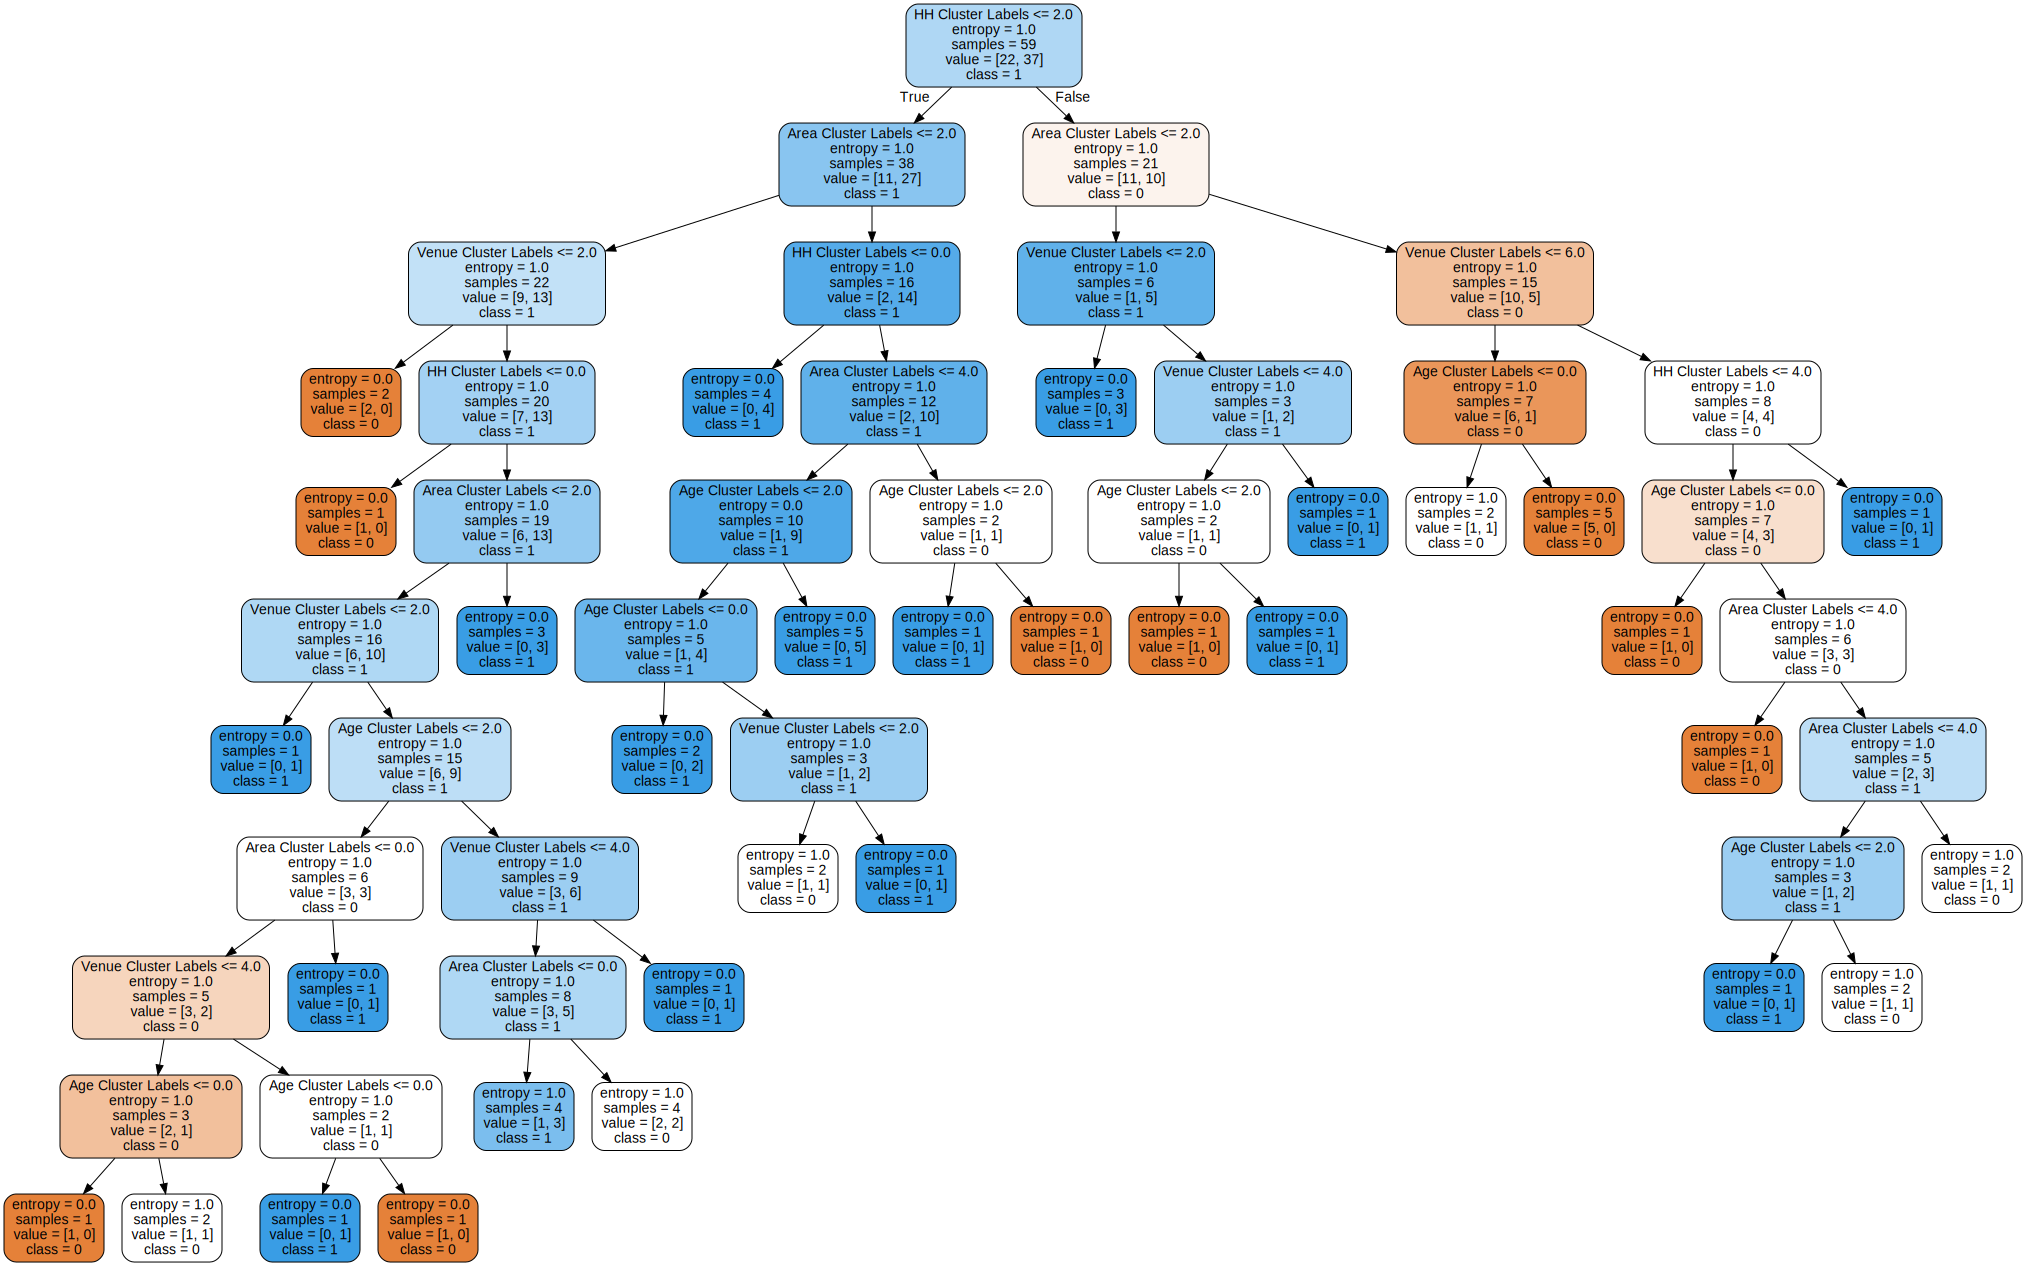

In [57]:
import graphviz 
dot_data = tree.export_graphviz(
    clf, 
    feature_names=X.columns.values,
    class_names=list(map(str,range(max(Y)+1))),
    filled=True, rounded=True, precision=0,
    out_file=None) 
graph = graphviz.Source(dot_data, format='svg')
graph.render(filename='figs/decision')
graph

In [58]:
df_topfeatures = pd.DataFrame({'Feature': X.columns.values, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False).head().reset_index()
df_topfeatures

index               Feature  Importance
0      1    Age Cluster Labels    0.327985
1      2   Area Cluster Labels    0.303342
2      0  Venue Cluster Labels    0.218471
3      3     HH Cluster Labels    0.150202

In [82]:
sns.scatterplot(x='Age', y='Churn', data=df_cologne_result)

AttributeError: module 'seaborn' has no attribute 'scatterplot'